## Environment Setting
Google drive mount (for Colab users) and package importing.
You can optionally install and import torchensemble package for ensemble learning

In [1]:
from google.colab import drive
drive.mount('mobilenet')

Mounted at mobilenet


In [2]:
# import package

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary


from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

from torchvision import utils
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import time
import copy

In [3]:
# specify path to data
transform = transforms.Compose(
    [transforms.ToTensor()])

train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

val_ds = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Depthwise, Pointwise convolution
class depth_point(nn.Module):
    def __init__(self, input_size, output_size, stride=1):
        super().__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(input_size, input_size, 3, stride=stride, padding=1, groups=input_size),
            nn.BatchNorm2d(input_size),
            nn.ReLU6(),
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(input_size, output_size, 1, stride=1, padding=0),
            nn.BatchNorm2d(output_size),
            nn.ReLU6()
        )
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

# Depthwise, Pointwise convolution + dilation 
class depth_point2(nn.Module):
    def __init__(self, input_size, output_size, padding ,stride=1):
        super().__init__()

        self.depthwise = nn.Sequential(
            nn.Conv2d(input_size, input_size, 3, stride=stride, padding=padding, dilation=2, groups=input_size),
            nn.BatchNorm2d(input_size),
            nn.ReLU6(),
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(input_size, output_size, 1, stride=1, padding=0),
            nn.BatchNorm2d(output_size),
            nn.ReLU6()
        )
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x



# MobileNetV1
class MobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.init = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.conv1 = depth_point(32, 64)

        self.conv2 = nn.Sequential(
            depth_point(64, 128 , stride=2),
            depth_point(128, 128)
        )

        self.conv3 = nn.Sequential(
            depth_point(128, 256, stride=2),
            depth_point(256, 256)
        )
        
        self.conv4 = depth_point(256, 512, stride=2)
        
        self.conv5 = nn.Sequential(
            depth_point(512, 512),
            depth_point(512, 512),
            depth_point(512, 512),
            depth_point(512, 512),
            depth_point(512, 512),
        )

        self.conv6 = nn.Sequential(
            depth_point(512, 1024, stride=2)
        )

        self.conv7 = nn.Sequential(
            depth_point(1024, 1024, stride=2)
        )

        self.convd1 = nn.Conv2d(3, 32, 1, stride=1, padding=0, dilation=1)      ## channel
        self.pool1 = nn.AvgPool2d(2,2)
      
        self.convd2 = nn.Conv2d(32, 64, 1, stride=1, padding=0, dilation=1)      
        self.pool2 = nn.AvgPool2d(1,1)

        self.convd3 = nn.Conv2d(64, 128, 1, stride=1, padding=0, dilation=1)      

        self.convd4 = nn.Conv2d(128, 256, 1, stride=1, padding=0, dilation=1)
        self.convd5 = nn.Conv2d(256, 512, 1, stride=1, padding=0, dilation=1)
        self.convd7 = nn.Conv2d(512, 1024, 1, stride=1, padding=0, dilation=1)

        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        x1 = self.init(x) + self.pool1(self.convd1(x))
        x2 = self.conv1(x1) + self.pool2(self.convd2(x1))
        x3 = self.conv2(x2) + self.pool1(self.convd3(x2))
        x4 = self.conv3(x3) + self.pool1(self.convd4(x3))
        x5 = self.conv4(x4) + self.pool1(self.convd5(x4))       
        x6 = self.conv5(x5) + x5
        x7 = self.conv6(x6) + self.pool1(self.convd7(x6)) 
        x8 = self.conv7(x7) + x7
        x9 = self.pool(x8)
        x10 = x9.view(x9.size(0), -1)
        x11 = self.fc(x10)
        return x11
    
def mobilenet():
    return MobileNet()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn((32, 3, 32, 32)).to(device)
model = mobilenet().to(device)
output = model(x)
print('output size:', output.size())
summary(model, (3, 32, 32), device=device.type)

output size: torch.Size([32, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              ReLU-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 32, 32]             128
         AvgPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]             320
       BatchNorm2d-7           [-1, 32, 16, 16]              64
             ReLU6-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]           2,112
      BatchNorm2d-10           [-1, 64, 16, 16]             128
            ReLU6-11           [-1, 64, 16, 16]               0
      depth_point-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]           2,112
     

In [6]:
# define loss function, optimizer, lr_scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = MobileNet().to(device)
loss_func = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.005)


# Function to train the network

def train_val(net, params_train): #, model_path='./cifar_net.pth'
    max_epoch=params_train['max_epoch']
    trainloader=params_train['train_dl']
    testloader=params_train['val_dl']
    crit=params_train['loss_func']
    opt=params_train['optimizer']
    path2weights = params_train['path2weights']
    history = []
    best_model_wts = copy.deepcopy(net.state_dict())
    start_time = time.time()
    best_loss = float('inf')
    
    for epoch in range(max_epoch):  # loop over the dataset multiple times

        print('Epoch {}/{}'.format(epoch+1, max_epoch))
        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels      
            inputs, labels = data

            # Training on GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            opt.zero_grad()

            outputs = net(inputs)

            loss = crit(outputs, labels)
            loss.backward()
            opt.step()
 
            running_loss += loss.item()
        train_loss = running_loss / 50000

        net.eval()
        with torch.no_grad():
            running_loss_1 = 0.0
            running_metric_1 = 0.0
            for j, data_1 in enumerate(testloader, 0):
                    # get the inputs; data is a list of [inputs, labels]

                    inputs_1, labels_1 = data_1
                    inputs_1 = inputs_1.to(device)
                    labels_1 = labels_1.to(device)
     
                    # forward
                    outputs_1 = net(inputs_1)
                    loss1 = crit(outputs_1, labels_1)
                    

                    pred1 = outputs_1.argmax(1, keepdim=True)
                    metrics = pred1.eq(labels_1.view_as(pred1)).sum().item()
                    if metrics is not None:
                       running_metric_1 += metrics
                    # print statistics
                    running_loss_1 += loss1.item()                      
            metrix = running_metric_1 / 10000
            val_loss = running_loss_1 / 10000
            
            
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(net.state_dict())
            torch.save(net.state_dict(), path2weights)
            print('Copied best model weights!')

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*metrix, (time.time()-start_time)/60))
        history.append(metrix)
        print('-'*10)
        

    net.load_state_dict(best_model_wts)           
    #torch.save(net.state_dict(), model_path)
    print('Finished Training')
    print('Saved Trained Model')
    return history  

cuda


In [7]:
# define the training parameters
params_train = {
    'max_epoch':30,
    'optimizer':optimizer,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [8]:
history =  train_val(model, params_train)

Epoch 1/30
Copied best model weights!
train loss: 1.736980, val loss: 1.539376, accuracy: 48.31, time: 1.2232 min
----------
Epoch 2/30
train loss: 1.315483, val loss: 1.644268, accuracy: 49.61, time: 2.4272 min
----------
Epoch 3/30
Copied best model weights!
train loss: 1.168257, val loss: 1.250791, accuracy: 58.56, time: 3.6282 min
----------
Epoch 4/30
Copied best model weights!
train loss: 1.072004, val loss: 1.131144, accuracy: 61.81, time: 4.8293 min
----------
Epoch 5/30
Copied best model weights!
train loss: 1.012195, val loss: 0.908154, accuracy: 69.00, time: 6.0356 min
----------
Epoch 6/30
train loss: 0.952002, val loss: 0.974480, accuracy: 67.75, time: 7.2463 min
----------
Epoch 7/30
train loss: 0.921251, val loss: 1.116291, accuracy: 65.50, time: 8.4701 min
----------
Epoch 8/30
Copied best model weights!
train loss: 0.864610, val loss: 0.831154, accuracy: 71.67, time: 9.7335 min
----------
Epoch 9/30
train loss: 0.842218, val loss: 1.105375, accuracy: 65.89, time: 10.99

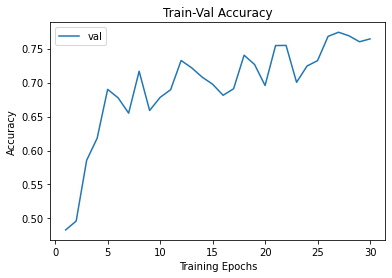

In [10]:
# train-val progress
num_epochs = params_train['max_epoch']
# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), history, label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()